In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/database/captcha-samples-wordpress.zip ./


In [ ]:
!unzip captcha-samples-wordpress.zip

Archive:  captcha-samples-wordpress.zip
replace test/UL8M.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -1 train/ | wc -l

9844


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist
import cv2
from glob import glob
import os
from keras.models import load_model

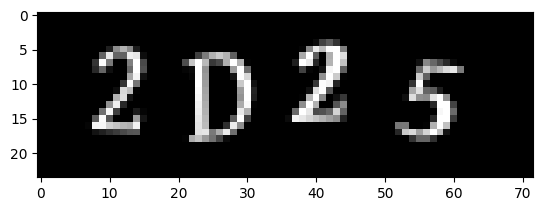

In [ ]:
im=cv2.imread('train/2D25.png')
im=255-cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)/255.0
plt.imshow(im,'gray')

In [ ]:
def load_data(p):
  pattern=os.path.join(p,'*.png')
  files=glob(pattern)
  images=[]
  targets=[]
  for file in files:
    chars=list(os.path.splitext(os.path.basename(file))[0])
    if len(chars)!=4:
      continue
    targets.append(chars)
    im=cv2.imread(file)
    im=(255-cv2.cvtColor(im,cv2.COLOR_BGR2GRAY))/255.0
    images.append(im)
  images=np.array(images,ndmin=3)
  targets=np.array(targets,ndmin=2)
  return images,targets

In [ ]:
X,Y=load_data('train/')
X_test,Y_test=load_data('test/')
print(X.shape,Y.shape)
print(X_test.shape,Y_test.shape)

(9843, 24, 72) (9843, 4)
(100, 24, 72) (100, 4)


In [ ]:
encoder=LabelEncoder()
Y_encoded=encoder.fit(Y.reshape(-1))
with open('encoder.bin','wb') as f:
  pickle.dump(encoder,f)

In [ ]:
Y_encoded=encoder.transform(Y.reshape(-1)).reshape(-1,4)
Y_encoded_test=encoder.transform(Y_test.reshape(-1)).reshape(-1,4)
print(Y_encoded.shape)

(9843, 4)


In [ ]:
def build_model():
  model=Sequential()
  model.add(Input(shape=(24, 72,1)))
  model.add(Conv2D(4,(3,3),padding='same'))
  model.add(Conv2D(8,(3,3),padding='same'))
  model.add(MaxPool2D(2,2))
  model.add(Conv2D(16,(3,3),padding='same'))
  model.add(Conv2D(32,(3,3),padding='same'))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(32,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model
def fit_images(X,Y,XT,YT):
  yt=to_categorical(Y)
  yt_test=to_categorical(YT)
  model=build_model()
  H=model.fit(X,yt,validation_data=(XT,yt_test),epochs=30,verbose=False)
  train_acc=model.evaluate(X,yt)
  test_acc=model.evaluate(XT,yt_test)
  return model,train_acc,test_acc

In [ ]:
models=[]
for i in range(4):
  model=fit_images(X,Y_encoded[:,i],X_test,Y_encoded_test[:,i])
  models.append(model)


308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9994 - loss: 9.5774e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7359e-04
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9919 - loss: 0.0301
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.8280e-04
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.0016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0045    
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.7196e-06
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0319     


In [ ]:
for i in range(4):
  models[i][0].save(f'model_char_{i}.h5')

In [ ]:
def predict(X):
  with open('encoder.bin', 'rb') as f:
    encoder = pickle.load(f)
  models = []
  chars = []
  for i in range(4):
    models.append(load_model(f'model_char_{i}.h5'))
    p = models[-1].predict(X.reshape(1, 24, 72), verbose=False)
    p = np.argmax(p)
    p = encoder.inverse_transform([p])[0]
    chars.append(p)
  return "".join(chars)

def predict_image(path):
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im = (255 - im) / 255.0
  return predict(im)



In [ ]:
f = 'test/CFCG.png'
out = predict_image(f)
out


'CFCG'